# Data Analysis

## Task

Analyze course information provided by the Computer Science department at Emory University for the last 10 years (2008 ~ 2018).

## CSV File

Read [cs_courses_2008_2018.csv](../dat/cs_courses_2008_2018.csv), where each column contains the following information:

* `0`: Term
* `1`: Career
* `2`: Class Number
* `3`: Subject
* `4`: Catalog Number
* `5`: Section
* `6`: Title
* `7`: Topic
* `8`: Mininum Hours
* `9`: Maximum Hours
* `10`: Maximum Enrollment
* `11`: Enrollment
* `12`: Instructor Name
* `13`: Grade Basis
* `14`: Class Status

In [43]:
import csv

csv_file = '../dat/cs_courses_2008_2018.csv'

with open(csv_file) as fin:
    reader = csv.reader(fin)
    course_info = [row for i, row in enumerate(reader)]

print(len(course_info))

1254


Skip the header (first row) and courses that:

* have 0 enrollment, or
* have no instructor, or
* are not active.

In [44]:
def skip(i, row):
    return i == 0 or \
           int(row[11]) == 0 or \
           row[12].strip() == '' or \
           row[14].strip() != 'Active'

Collect necessary information from each row.

In [45]:
def info(row):
    # term is normalized to (year, term_id) (e.g., 5181 -> (2018, 1))
    # term_id = 1: Spring, 6: Summer, 9: Fall
    r = row[0]
    term = (2000 + int((int(r) - 5000) / 10), int(r[-1]))

    return {'term': term,
            'subject': row[3].strip(),
            'catalog': row[4].strip(),
            'section': row[5].strip(),
            'title': row[6].strip(),
            'min_hours': int(row[8]),
            'max_hours': int(row[9]),
            'enrollment': int(row[11]),
            'instructor': row[12].strip()}

Use [namespace](https://docs.python.org/library/types.html#types.SimpleNamespace) instead of dictionary for easy access to these fields, and split the instructor name into (lastname, firstname).

In [46]:
from types import SimpleNamespace

def info(row):
    # term is normalized to (year, term_id) (e.g., 5181 -> (2018, 1))
    # term_id = 1: Spring, 6: Summer, 9: Fall
    r = row[0]
    term = (2000 + int((int(r) - 5000) / 10), int(r[-1]))
    
    # name = lastname,firstname
    r = row[12].split(',')
    instructor = (r[0].strip(), r[1].strip())

    return SimpleNamespace(
        term=term,
        subject=row[3].strip(),
        catalog=row[4].strip(),
        section=row[5].strip(),
        title=row[6].strip(),
        min_hours=int(row[8]),
        max_hours=int(row[9]),
        enrollment=int(row[11]),
        instructor=instructor)

Create a function that returns the list of all course information.

In [47]:
def load_course_info(csv_file):
    with open(csv_file) as fin:
        reader = csv.reader(fin)
        course_info = [info(row) for i, row in enumerate(reader) if not skip(i, row)]
    
    return course_info

course_info = load_course_info(csv_file)
print(len(course_info))

1031


## Data Retrieval

Retrieve the number of enrollments by terms.

In [48]:
def enrollment_by_term(course_info):
    enroll = {}
    for c in course_info:
        term = c.term
        enroll[term] = enroll.get(term, 0) + c.enrollment
    
    return enroll

d = enrollment_by_term(course_info)
for k, v in sorted(d.items()): print(k, v)

(2008, 9) 311
(2009, 1) 268
(2009, 6) 37
(2009, 9) 408
(2010, 1) 275
(2010, 6) 23
(2010, 9) 439
(2011, 1) 417
(2011, 6) 35
(2011, 9) 578
(2012, 1) 481
(2012, 6) 40
(2012, 9) 578
(2013, 1) 653
(2013, 6) 40
(2013, 9) 763
(2014, 1) 785
(2014, 6) 81
(2014, 9) 763
(2015, 1) 949
(2015, 6) 73
(2015, 9) 1016
(2016, 1) 1107
(2016, 6) 53
(2016, 9) 1099
(2017, 1) 1031
(2017, 6) 135
(2017, 9) 1191
(2018, 1) 1096


In [49]:
def term_to_year(term):
    """
    :param term: a tuple of (year, term_id).
    """
    return term[0] if term[1] == 9 else term[0] - 1

In [50]:
def enrollment_by_academic_year(course_info):
    enroll = {}
    for c in course_info:
        year = term_to_year(c.term)
        enroll[year] = enroll.get(year, 0) + c.enrollment
    
    return enroll

d = enrollment_by_academic_year(course_info)
for k, v in sorted(d.items()): print(k, v)

2008 616
2009 706
2010 891
2011 1099
2012 1271
2013 1629
2014 1785
2015 2176
2016 2265
2017 2287


Plot the number of enrollments by academic years.

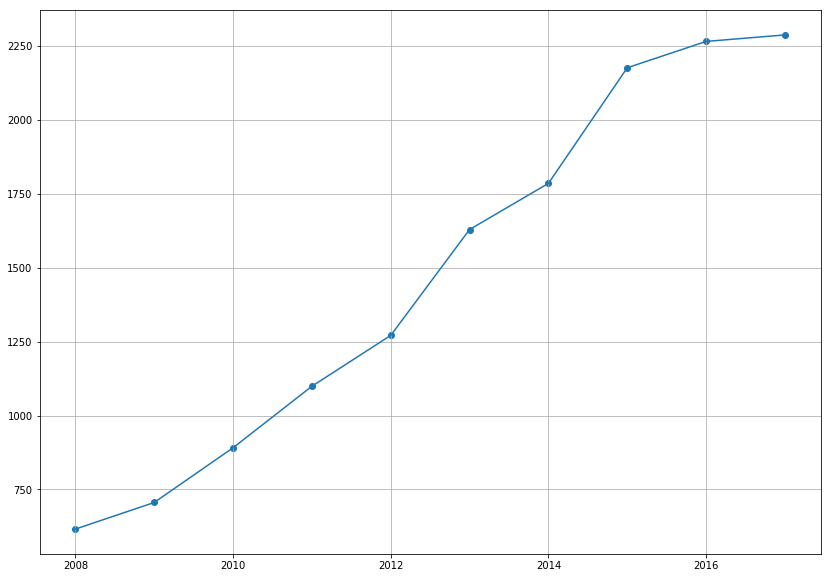

In [51]:
import matplotlib.pyplot as plt

def plot_dict(d):
    xs, ys = zip(*[(k, v) for k, v in sorted(d.items())])
    plt.scatter(xs, ys)
    plt.plot(xs, ys)
    plt.grid(b='on')
    plt.show()

plot_dict(d)

Retrieve the number of enrollments by academic years selectively:

* Regular courses.
* Research courses.
* Undergraduate courses.
* Graduate courses.

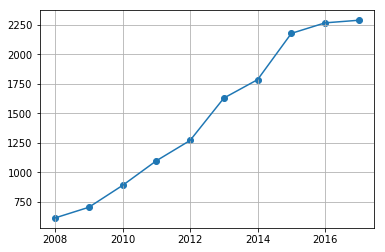

In [52]:
def enrollment_by_academic_year(course_info, regular=True, research=True, undergraduate=True, graduate=True):
    enroll = {}
    for c in course_info:
        # research courses include 'R' in the catalog, except for '130R'
        if c.catalog != '130R' and 'R' in c.catalog:
            if not research: continue
        elif not regular:
            continue
        
        # undergraduate courses are < 500
        if int(c.catalog[0]) < 5:
            if not undergraduate: continue
        elif not graduate:
            continue
        
        year = term_to_year(c.term)
        enroll[year] = enroll.get(year, 0) + c.enrollment
    
    return enroll

d = enrollment_by_academic_year(course_info)
plot_dict(d)

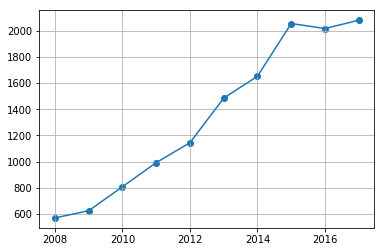

In [53]:
d = enrollment_by_academic_year(course_info, research=False)
plot_dict(d)

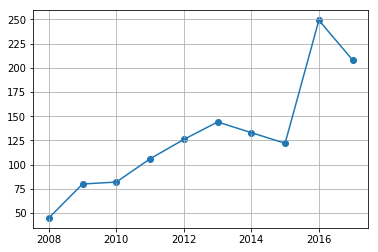

In [54]:
d = enrollment_by_academic_year(course_info, regular=False)
plot_dict(d)

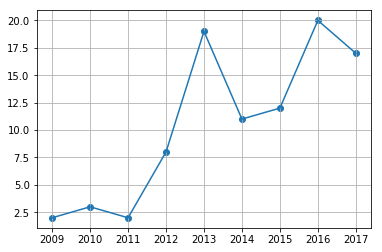

In [55]:
d = enrollment_by_academic_year(course_info, regular=False, graduate=False)
plot_dict(d)

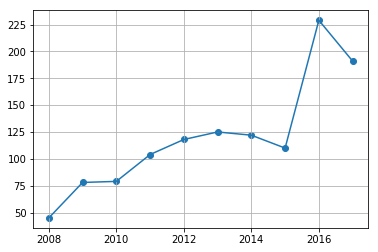

In [56]:
d = enrollment_by_academic_year(course_info, regular=False, undergraduate=False)
plot_dict(d)

Retrieve the set of instructors by terms.

Use namespace instead of dictionary, and split the name into (lastname, firstname).

In [57]:
def instructor_by_term(course_info):
    inst = {}
    for c in course_info:
        if c.term in inst:
            inst[c.term].add(c.instructor)
        else:
            inst[c.term] = {c.instructor}

    return inst

d = instructor_by_term(course_info)
for k, v in sorted(d.items()): print(k, len(v))

(2008, 9) 9
(2009, 1) 12
(2009, 6) 1
(2009, 9) 14
(2010, 1) 13
(2010, 6) 5
(2010, 9) 14
(2011, 1) 19
(2011, 6) 4
(2011, 9) 20
(2012, 1) 22
(2012, 6) 4
(2012, 9) 20
(2013, 1) 22
(2013, 6) 5
(2013, 9) 24
(2014, 1) 28
(2014, 6) 7
(2014, 9) 30
(2015, 1) 24
(2015, 6) 3
(2015, 9) 19
(2016, 1) 23
(2016, 6) 5
(2016, 9) 21
(2017, 1) 24
(2017, 6) 11
(2017, 9) 21
(2018, 1) 24


Normalize terms to a readable form.

In [58]:
def term_to_str(term):
    year = term[0]
    if term[1] == 1: t = 'Spring'
    elif term[1] == 6: t = 'Summer'
    elif term[1] == 9: t = 'Fall'
    else: t = ''
    return t, year

for k, v in sorted(d.items()): print(term_to_str(k), len(v))

('Fall', 2008) 9
('Spring', 2009) 12
('Summer', 2009) 1
('Fall', 2009) 14
('Spring', 2010) 13
('Summer', 2010) 5
('Fall', 2010) 14
('Spring', 2011) 19
('Summer', 2011) 4
('Fall', 2011) 20
('Spring', 2012) 22
('Summer', 2012) 4
('Fall', 2012) 20
('Spring', 2013) 22
('Summer', 2013) 5
('Fall', 2013) 24
('Spring', 2014) 28
('Summer', 2014) 7
('Fall', 2014) 30
('Spring', 2015) 24
('Summer', 2015) 3
('Fall', 2015) 19
('Spring', 2016) 23
('Summer', 2016) 5
('Fall', 2016) 21
('Spring', 2017) 24
('Summer', 2017) 11
('Fall', 2017) 21
('Spring', 2018) 24


## Levenshtein Distance

Match professor names in `course_info`.

### Exercise

```python
def when_did_prof_x_start_teaching_cs_at_emory(course_info, lastname=None, firstname=None):
    """
    :param course_info: the output of load_course_info().
    :param lastname: the last name of the professor.
    :param firstname: the first name of the professor.
    :return: if both lastname and firstname are provided, the list of all instructors with their first terms.
          if only lastname is provided, the list of all instructors with the last name with their first terms.
          if only firstname is provided, the list of all instructors with the first name with their first terms.
    """
```

In [59]:
def match(instructor, lastname, firstname):
    l = not lastname or instructor[0] == lastname
    f = not firstname or instructor[1] == firstname
    return l and f

In [60]:
def when_did_prof_x_start_teaching_cs_at_emory(course_info, lastname=None, firstname=None):
    # both lastname and firstname are provided
    if lastname and firstname:
        n = next((c for c in course_info if match(c.instructor, lastname, firstname)), None)
        return [(*n.instructor, *term_to_str(n.term))] if n else []

    # only lastname or firstname is provided
    inst = {}

    for c in course_info:
        key = c.instructor
        if match(key, lastname, firstname) and key not in inst:
            inst[key] = term_to_str(c.term)

    return [(*k, *v) for k, v in inst.items()]

In [61]:
lastname = 'Choi'
insts = when_did_prof_x_start_teaching_cs_at_emory(course_info, lastname=lastname)
print(insts)

[('Choi', 'Jinho D', 'Fall', 2014)]


In [62]:
lastname = 'Jurczyk'
insts = when_did_prof_x_start_teaching_cs_at_emory(course_info, lastname=lastname)
print(insts)

[('Jurczyk', 'Pawel Czeslaw', 'Spring', 2009), ('Jurczyk', 'Tomasz Marek', 'Spring', 2014)]


In [63]:
firstname = 'Jinho'
insts = when_did_prof_x_start_teaching_cs_at_emory(course_info, firstname=firstname)
print(insts)

[]


Allow partial matching.

In [64]:
def match(instructor, lastname, firstname):
    l = not lastname or lastname.lower() in set(instructor[0].lower().split())
    f = not firstname or firstname.lower() in set(instructor[1].lower().split())
    return l and f

In [65]:
firstname = 'Jinho'
insts = when_did_prof_x_start_teaching_cs_at_emory(course_info, firstname=firstname)
print(insts)

[('Choi', 'Jinho D', 'Fall', 2014)]


In [66]:
firstname = 'Shun Yan'
insts = when_did_prof_x_start_teaching_cs_at_emory(course_info, firstname=firstname)
print(insts)

[]


Allow fuzzy matching using the [`fuzzywuzzy`](https://github.com/seatgeek/fuzzywuzzy) package based on the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance).

In [67]:
from fuzzywuzzy import fuzz

def match(instructor, lastname, firstname, threshold):
    l = not lastname or fuzz.ratio(lastname.lower(), instructor[0].lower()) >= threshold
    f = not firstname or fuzz.ratio(firstname.lower(), instructor[1].lower()) >= threshold
    return l and f

In [68]:
def when_did_prof_x_start_teaching_cs_at_emory(course_info, lastname=None, firstname=None, threshold=75):
    # both lastname and firstname are provided
    if lastname and firstname:
        n = next((c for c in course_info if match(c.instructor, lastname, firstname, threshold)), None)
        return [(*n.instructor, *term_to_str(n.term))] if n else []

    # only lastname or firstname is provided
    inst = {}

    for c in course_info:
        key = c.instructor
        if match(key, lastname, firstname, threshold) and key not in inst:
            inst[key] = term_to_str(c.term)

    return [(*k, *v) for k, v in inst.items()]

In [69]:
firstname = 'Shun Yan'
insts = when_did_prof_x_start_teaching_cs_at_emory(course_info, firstname=firstname)
print(insts)

[('Cheung', 'Shun Yan', 'Fall', 2011)]


In [70]:
firstname = 'Shun Yang'
insts = when_did_prof_x_start_teaching_cs_at_emory(course_info, firstname=firstname)
print(insts)

[('Cheung', 'Shun Yan', 'Fall', 2011)]


In [71]:
firstname = 'ShunYan'
insts = when_did_prof_x_start_teaching_cs_at_emory(course_info, firstname=firstname)
print(insts)

[('Cheung', 'Shun Yan', 'Fall', 2011)]


## $TF_{t,d} \cdot IDF_{t}$

Retrive courses taught by a certain professor.

In [72]:
def is_research_course(catalog):
    return catalog != '130R' and 'R' in catalog

### Exercise

```python
def course_by_instructor(course_info, lastname, include_research=False):
    """
    :param course_info: the output of load_course_info()
    :param lastname: the last name of the professor.
    :param include_research: if True, include research courses; otherwise, exclude them.
    :return: a dictionary where the key is the course number and 
             the value is the number of terms that the professor `lastname` taught that course.
    """
```

In [73]:
from collections import Counter

def course_by_instructor(course_info, lastname, include_research=False):
    def match(c):
        return c.instructor[0] == lastname and \
               (include_research or not is_research_course(c.catalog))

    courses = {(*c.term, c.subject, c.catalog) for c in course_info if match(c)}
    return Counter([t[2:] for t in courses])

course_by_instructor(course_info, 'Choi')

Counter({('CS', '323'): 5,
         ('CS', '325'): 1,
         ('CS', '329'): 1,
         ('CS', '571'): 2})

In [74]:
def courses_by_instructors(course_info, include_research=False):
    d = {}
    for c in course_info:
        if include_research or not is_research_course(c.catalog):
            key = c.instructor
            val = (*c.term, c.subject, c.catalog)
            if key in d: d[key].add(val)
            else: d[key] = {val}

    return {k: Counter([t[2:] for t in v]) for k, v in d.items()}

prof_course_dict = courses_by_instructors(course_info)
print(len(prof_course_dict))

78


Measure [$TF_{t,d} \cdot IDF_{t}$](https://en.wikipedia.org/wiki/Tf–idf):

* Term Frequence: $TF_{t,d}$ = how many times that the term $t$ appears in the document $d$.
* Document Frequency: $DF_{t}$ = how many documents include the term $t$.
* Inverse Document Frequency: $IDF_{t} = \log(\frac{N}{DF_{t}})$, where $N$ is the total number of documents.

In our case, each professor is considered a document and each course is considered a term.

```python
def professor_frequency(prof_course_dict):
    """
    :param prof_course_dict: the output of courses_by_instructors().
    :return: the counter where the key is (subject, catalog) and the value is its frequency count 
             with respect to professors.
    """
```

In [75]:
def professor_frequency(prof_course_dict):
    return Counter([k for v in prof_course_dict.values() for k in v.keys()])
        
prof_freq = professor_frequency(prof_course_dict)
print(prof_freq)

Counter({('CS', '170'): 39, ('CS', '584'): 18, ('CS', '171'): 17, ('CS', '130R'): 11, ('CS', '224'): 9, ('CS', '323'): 7, ('CS', '485'): 6, ('CS', '255'): 5, ('CS', '377'): 5, ('CS', '325'): 4, ('CS', '370'): 4, ('CS', '110'): 4, ('CS', '190'): 3, ('CS', '730'): 3, ('CS', '590'): 3, ('CS', '534'): 3, ('CS', '540'): 3, ('CS', '424'): 3, ('CS', '572'): 2, ('CS', '571'): 2, ('CS', '455'): 2, ('CS', '554'): 2, ('CS', '558'): 2, ('CS', '574'): 2, ('CS', '570'): 2, ('CS', '155'): 2, ('CS', '425'): 1, ('CS', '557'): 1, ('CS', '559'): 1, ('CS', '355'): 1, ('CS', '561'): 1, ('CS', '329'): 1, ('CS', '153'): 1, ('CS', '526'): 1, ('CS', '524'): 1, ('CS', '740'): 1, ('CS', '563'): 1, ('CS', '556'): 1, ('CS', '171Z'): 1, ('CS', '456'): 1, ('CS', '285'): 1, ('CS', '450'): 1, ('CS', '551'): 1, ('CS', '580'): 1, ('CS', '452'): 1, ('CS', '720'): 1, ('CS', '555'): 1, ('CS', '453'): 1, ('CS', '573'): 1, ('CS', '378'): 1})


### Exercise

```python
def what_is_prof_x_special_courses(course_info, lastname):
    """
    :param course_info: the output of load_course_info().
    :param lastname: the last name of the professor.
    :return: a dictionary where the key is (subject, catalog) and value is its TF-IDF score.
    """
```

In [95]:
import math

def what_is_prof_x_special_courses(course_info, lastname):
    prof_course_dict = courses_by_instructors(course_info)
    prof_freq = professor_frequency(prof_course_dict)
    prof_courses = course_by_instructor(course_info, lastname)  # this is inefficient
    N = len(prof_freq)
    
    for k, v in prof_courses.items():
        prof_courses[k] *= math.log(N / prof_freq[k])
        
    return prof_courses
        
d = what_is_prof_x_special_courses(course_info, 'Choi')
for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True): print(k, v)

('CS', '323') 9.830564281864163
('CS', '571') 6.437751649736401
('CS', '329') 3.912023005428146
('CS', '325') 2.5257286443082556


## Vector Space Model

Create a vector representation of each professor with respect to their courses.

### Exercise

```python
def prof_to_vec(course_info):
    """
    "param course_info: the output of load_course_info().
    :return: a dictionary where the key is professor's name and the value is a numpy array whose length is the 
             total number of courses and each dimension in the array represents the TF-IDF score of each course.
    """
```

In [97]:
import numpy as np

def prof_to_vec(course_info):
    prof_course_dict = courses_by_instructors(course_info)
    prof_freq = professor_frequency(prof_course_dict)
    N = len(prof_freq)
    course_dict = {c: i for i, c in enumerate(sorted(list(prof_freq.keys())))}
    p2v = {}
    
    for prof_name, counts in prof_course_dict.items():
        vec = np.zeros(len(course_dict))
        
        for k, v in counts.items():
            if k in course_dict:
                i = course_dict[k]
                vec[i] = v * math.log(N / prof_freq[k])
        
        p2v[prof_name] = vec
    
    return p2v

p2v = prof_to_vec(course_info)
print(p2v[('Choi', 'Jinho D')])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          9.83056428  2.52572864
  3.91202301  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  6.43775165  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


Normalize each vector such that the sum of all values in any vector equals to `1`.

In [78]:
def prof_to_vec(course_info, normalize=True, include_research=False):
    prof_course_dict = courses_by_instructors(course_info, include_research)
    prof_freq = professor_frequency(prof_course_dict)
    N = len(prof_freq)
    course_dict = {c: i for i, c in enumerate(sorted(list(prof_freq.keys())))}
    p2v = {}
    
    for prof_name, counts in prof_course_dict.items():
        vec = np.zeros(len(course_dict))
        
        for k, v in counts.items():
            if k in course_dict:
                i = course_dict[k]
                vec[i] = v * math.log(N / prof_freq[k])
        
        if normalize: vec /= sum(vec)
        p2v[prof_name] = vec
    
    return p2v

p2v = prof_to_vec(course_info)
print(p2v[('Choi', 'Jinho D')])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.43294878  0.11123585
  0.17228976  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.28352561  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


## Dimensionality Reduction

Create a 2D numpy array where each row represents the vector of a professor.

In [79]:
profs = sorted(p2v.keys())
vectors = np.array([p2v[p] for p in profs])

Perform [Principle Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce dimensionality of these vectors using [sklearn.decomposition.PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

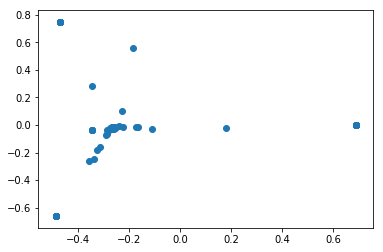

In [80]:
from sklearn.decomposition import PCA

xy = PCA(n_components=2).fit_transform(vectors)
fig, ax = plt.subplots()
ax.scatter(xy[:,0], xy[:,1])
plt.show()

Perform [t-distributed Stochastic Neighbor Embedding (t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), another method for dimensionality reduction, using [sklearn.manifold.TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

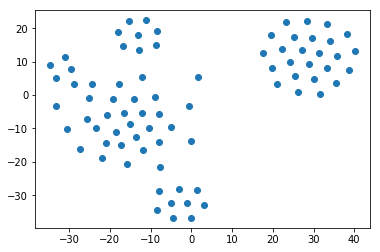

In [88]:
from sklearn.manifold import TSNE

xy = TSNE(n_components=2).fit_transform(vectors)
fig, ax = plt.subplots()
ax.scatter(xy[:,0], xy[:,1])
plt.show()

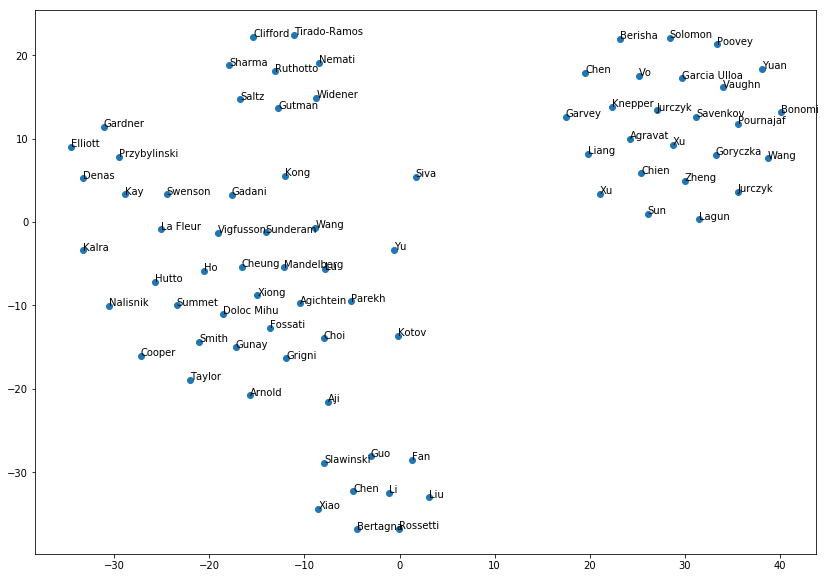

In [89]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)

x = xy[:,0]
y = xy[:,1]
ax.scatter(x, y)

for i, p in enumerate(profs):
    ax.annotate(p[0], (x[i], y[i]))
    
plt.show()

## Similarity Measurement

* [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance): $\lVert \mathrm{x} - \mathrm{y} \rVert$
* [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity): $\frac{\mathrm{x} \cdot \mathrm{y}}{\lVert\mathrm{x}\rVert \lVert\mathrm{y}\rVert}$

### Exercise

```
def euclidean(x, y):
    """
    :param x a numpy array
    :param y a numpy array
    :return: the euclidean distance between x and y.
    """

def cosine(x, y):
    """
    :param x a numpy array
    :param y a numpy array
    :return: the cosine similarity between x and y.
    """
```

In [92]:
import math

def euclidean(x, y):
    return math.sqrt(sum((x - y)**2))

def cosine(x, y):
    return np.dot(x, y) / (math.sqrt(np.dot(x, x)) * math.sqrt(np.dot(y, y)))

def ranked_list(profs, vectors, sim):
    d = {}
    for i, pi in enumerate(profs):
        dists = [(pj, sim(vectors[i], vectors[j])) for j, pj in enumerate(profs) if i != j]
        d[pi] = sorted(dists, key=lambda x: x[1], reverse=True)
    return d

In [93]:
ranks = ranked_list(profs, xy, euclidean)

for prof, dist in ranks[('Choi', 'Jinho D')][:10]:
    print('%35s: %6.4f' % (prof, dist))

                  ('Yuan', 'Shuai'): 56.3393
                 ('Bonomi', 'Luca'): 55.1903
              ('Poovey', 'Jason A'): 54.3438
      ('Vaughn', 'Christopher Lee'): 51.6721
                     ('Wang', 'Yu'): 51.4713
       ('Solomon', 'Michael Glenn'): 51.1822
             ('Pournajaf', 'Layla'): 50.6267
       ('Garcia Ulloa', 'Daniel A'): 48.8887
           ('Berisha', 'Sebastian'): 47.5068
              ('Savenkov', 'Denis'): 47.3443


In [94]:
ranks = ranked_list(profs, xy, cosine)

for prof, dist in ranks[('Choi', 'Jinho D')][:10]:
    print('%35s: %6.4f' % (prof, dist))

              ('Parekh', 'Ojas D.'): 0.9996
         ('Grigni', 'Michelangelo'): 0.9940
               ('Arnold', 'Dorian'): 0.9918
               ('Aji', 'Abulimiti'): 0.9834
('Slawinski', 'Jaroslaw Kazimierz'): 0.9681
                ('Xiao', 'Yonghui'): 0.9618
    ('Agichtein', 'Yevgeny Eugene'): 0.9557
               ('Fossati', 'David'): 0.9549
                ('Gunay', 'Cengiz'): 0.9447
          ('Taylor', 'James Peter'): 0.9423
